In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from keras.models import Sequential 
from keras.layers import LSTM, Dense , Dropout 
from keras.models import load_model, Model
%matplotlib inline


In [2]:
path ="F:/Practice/com"
items =pd.read_csv(path+'/items.csv')
item_cats= pd.read_csv(path+'/item_categories.csv')
shops= pd.read_csv(path+'/shops.csv')
sales= pd.read_csv(path+'/sales_train.csv')
test=pd.read_csv(path+'/test.csv')
submission = pd.read_csv(path+'/sample_submission.csv')
print("Data set loaded successfully.")

Data set loaded successfully.


In [3]:
sales['year'] = pd.to_datetime(sales['date'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y')))
sales['months'] = sales['date'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))

sales.head(5)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,months
0,02.01.2013,0,59,22154,999.00,1.0,2013-01-01,01
1,03.01.2013,0,25,2552,899.00,1.0,2013-01-01,01
2,05.01.2013,0,25,2552,899.00,-1.0,2013-01-01,01
3,06.01.2013,0,25,2554,1709.05,1.0,2013-01-01,01
4,15.01.2013,0,25,2555,1099.00,1.0,2013-01-01,01


<Axes: xlabel='months', ylabel='item_cnt_day'>

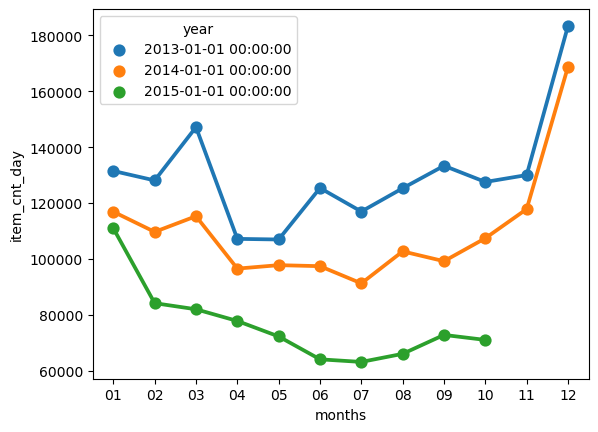

In [4]:
grouped = pd.DataFrame(sales.groupby(['year', 'months'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x= 'months', y='item_cnt_day', hue='year', data = grouped)

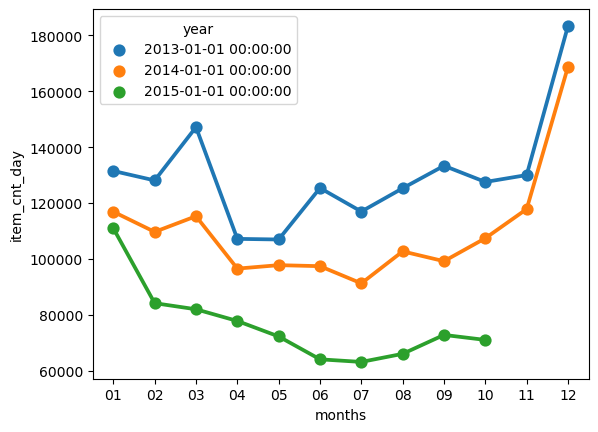

In [5]:
grouped = pd.DataFrame(sales.groupby(['year', 'months'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x='months', y='item_cnt_day', hue='year', data=grouped)
plt.show()


# Price


<Axes: xlabel='months', ylabel='item_price'>

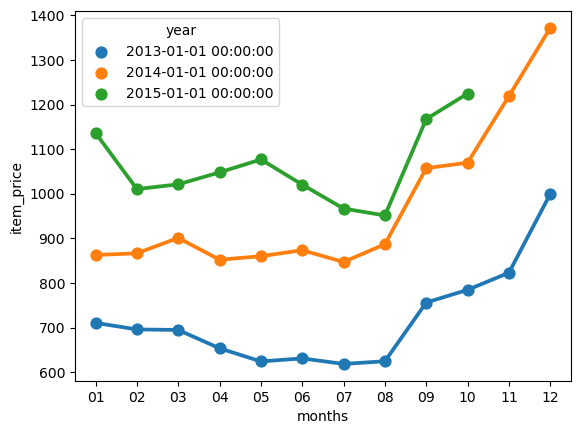

In [6]:
grouped_price =pd.DataFrame(sales.groupby(['year', 'months'])['item_price'].mean().reset_index())
sns.pointplot(x='months', y= 'item_price', hue= 'year', data= grouped_price)

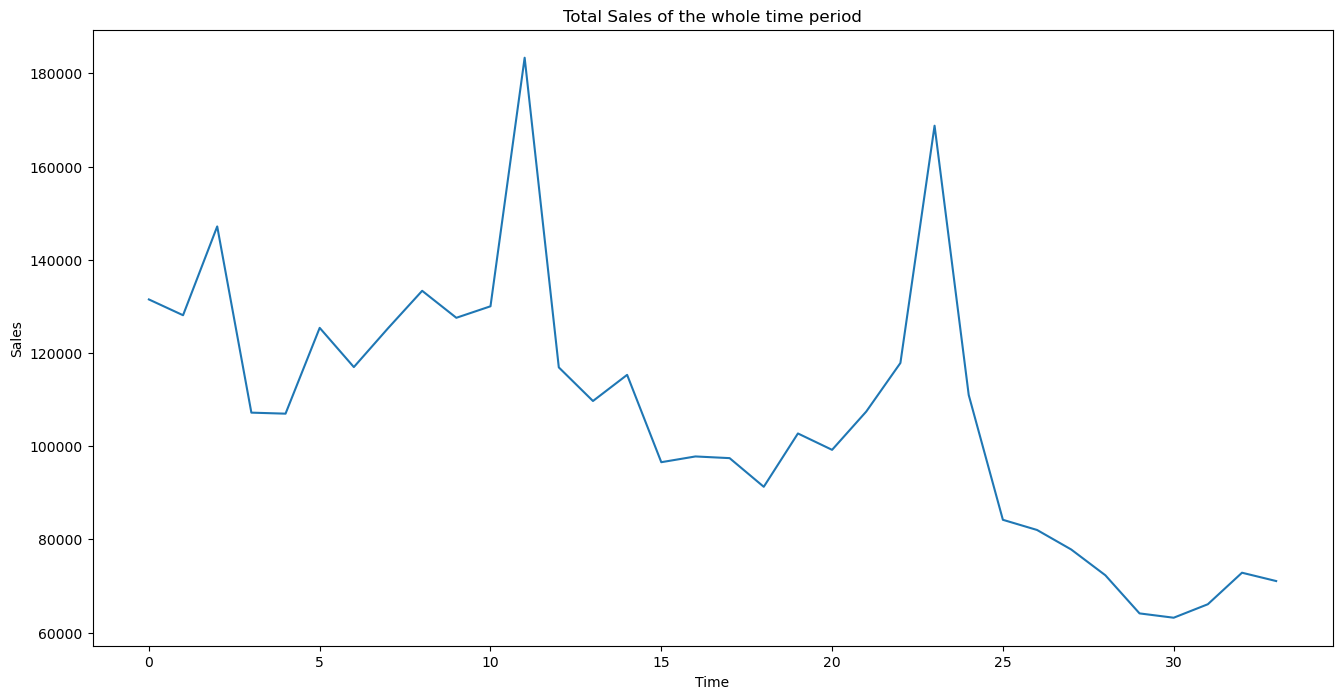

In [7]:
ts =sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the whole time period')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

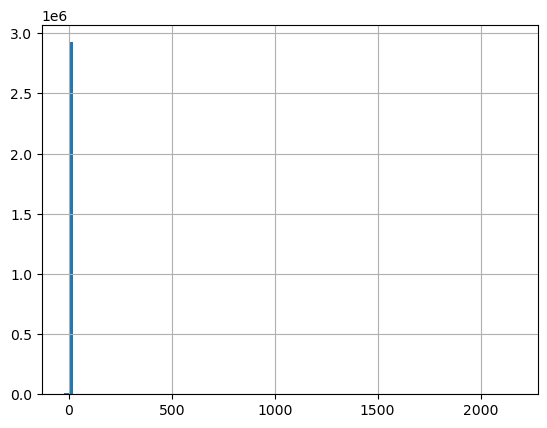

In [8]:
sales.item_cnt_day.hist(bins= 100)
sales.item_cnt_day.describe()

In [9]:
print('Data set size before remove item price 0 cleaning :', sales.shape)
sales = sales.query('item_price> 0')
print(' Data set size after remove item price 0 cleaning :', sales.shape)

Data set size before remove item price 0 cleaning : (2935849, 8)
 Data set size after remove item price 0 cleaning : (2935848, 8)


In [10]:
print ('Data set size before filter valid :', sales.shape )
#Only shops that exist in the test set.
sales = sales[sales['shop_id'].isin(test['shop_id'].unique())]
#Only items that exist in the test set
sales = sales[sales ['item_id'].isin(test['item_id'].unique())]
print('Data set size after filter valid:', sales.shape)

Data set size before filter valid : (2935848, 8)
Data set size after filter valid: (1224439, 8)


In [11]:
print('Data set size before removing outliers:', sales.shape)
sales = sales.query('item_cnt_day >= 0 and item_cnt_day <= 125 and item_price < 75000')
print('Data set size after removing outliers:', sales.shape)


Data set size before removing outliers: (1224439, 8)
Data set size after removing outliers: (1221451, 8)


# Aggregate to montly level the sales

In [12]:
monthly_sales = sales.groupby(["date_block_num", "shop_id", "item_id"]).agg(
    {"date_block_num":'mean', "date":['min','max'], "item_cnt_day":"sum"})



In [13]:
monthly_sales.head(5)

date_block_num        date              \
                                         mean         min         max   
date_block_num shop_id item_id                                          
0              2       33                 0.0  05.01.2013  05.01.2013   
                       482                0.0  16.01.2013  16.01.2013   
                       491                0.0  09.01.2013  09.01.2013   
                       839                0.0  22.01.2013  22.01.2013   
                       1007               0.0  11.01.2013  25.01.2013   

                               item_cnt_day  
                                        sum  
date_block_num shop_id item_id               
0              2       33               1.0  
                       482              1.0  
                       491              1.0  
                       839              1.0  
                       1007             3.0

In [14]:
sales_data_flat = monthly_sales['item_cnt_day'].apply(list).reset_index()
# Keep only the test data that is valid
sales_data_flat = pd.merge(test, sales_data_flat, on=['item_id', 'shop_id'], how='left')
sales_data_flat.fillna(0, inplace=True)
sales_data_flat.drop(['shop_id', 'item_id'], inplace=True, axis=1)
sales_data_flat.head(20)


,ID,date_block_num,sum
0,0,20.0,1.0
1,0,22.0,1.0
2,0,23.0,2.0
3,0,24.0,2.0
4,0,28.0,1.0
5,0,29.0,1.0
6,0,30.0,1.0
7,0,31.0,3.0
8,0,32.0,1.0
9,1,0.0,0.0


# Creating the Pivot table

In [15]:
pivoted_sales = sales_data_flat.pivot_table(index='ID', columns = 'date_block_num', fill_value =0,aggfunc ='sum')
pivoted_sales.head(20)

sum                                               ...       \
date_block_num 0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0   ... 24.0   
ID                                                                ...        
0                 0    0    0    0    0    0    0    0    0    0  ...    2   
1                 0    0    0    0    0    0    0    0    0    0  ...    0   
2                 0    0    0    0    0    0    0    0    0    0  ...    0   
3                 0    0    0    0    0    0    0    0    0    0  ...    0   
4                 0    0    0    0    0    0    0    0    0    0  ...    0   
5                 0    0    0    0    0    0    0    0    0    0  ...    1   
6                 0    0    0    0    0    0    0    0    0    0  ...    0   
7                 0    0    0    0    0    0    0    0    0    0  ...    0   
8                 0    0    0    0    0    0    0    0    0    0  ...    9   
9                 0    0    0    0    0    0    0    0    0    0  ...    0   
10                0    0    0    0    0    0    0    0    0    0  ...    4   
11                0    0    0    0    0    0    0    0    0    0  ...    0   
12                0    0    1    0    1    0    0    0    0    0  ...    0   
13                0    0    0    0    0    0    0    0    0    0  ...    3   
14                0    0    0    0    0    0    1    5    4    4  ...    7   
15                0    0    0    0    0    0    0    0    0    0  ...    4   
16                0    0    0    0    0    0    0    0    0    0  ...    0   
17                0    0    0    0    0    0    0    0    0    0  ...    0   
18                0    0    0    0    0    0    0    0    0    0  ...    0   
19                0    0    0    0    0    0    0    0    0    0  ...    0   

                                                             
date_block_num 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0  
ID                                                           
0                 0    0    0    1    1    1    3    1    0  
1                 0    0    0    0    0    0    0    0    0  
2                 0    0    0    3    2    0    1    3    1  
3                 0    0    0    0    0    0    1    0    0  
4                 0    0    0    0    0    0    0    0    0  
5                 0    0    0    3    0    0    0    1    1  
6                 0    0    0    0    0    0    0    3    2  
7                 0    1    0    0    1    0    0    0    0  
8                 2    3    2    2    4    3    2    3    0  
9                 0    0    0    0    0    0    0    0    0  
10                3    6    2    6    6    5    5    2    3  
11                0    0    0    0    0    0    0    1    0  
12                0    0    0    0    0    0    0    0    0  
13                3    1    0    0    3    1    1    0    0  
14                1    3    1    1    1    4    3    2    2  
15                1    7    1    6    1    1    2    1    6  
16                0    0    0    0    0    0    0    0    0  
17                0    0    0    0    1    0    0    0    0  
18                0    0    9    5    3    2    2    2    2  
19                0    0    0    0    0    0    0    0    0  

[20 rows x 34 columns]

In [16]:
X_train = np.expand_dims(pivoted_sales.values[:, :-1], axis=2)
y_train = pivoted_sales.values[:, -1:]
X_test = np.expand_dims(pivoted_sales.values[:, 1:], axis=2)
print(X_train.shape, y_train.shape, X_test.shape)


(214200, 33, 1) (214200, 1) (214200, 33, 1)


# LSTM MODEL Preparation

In [17]:
sales_model = Sequential()
sales_model.add(LSTM(units=64, input_shape=(33, 1)))
sales_model.add(Dropout(0.5))
sales_model.add(Dense(1))
sales_model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
sales_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
sales_model.fit(X_train, y_train, batch_size =2048, epochs = 50)

Epoch 1/50


105/105 [==============================] - 17s 142ms/step - loss: 5.6404 - mean_squared_error: 5.6404
Epoch 2/50
105/105 [==============================] - 15s 143ms/step - loss: 5.3387 - mean_squared_error: 5.3387
Epoch 3/50
105/105 [==============================] - 15s 144ms/step - loss: 5.2161 - mean_squared_error: 5.2161
Epoch 4/50
105/105 [==============================] - 15s 142ms/step - loss: 5.1612 - mean_squared_error: 5.1612
Epoch 5/50
105/105 [==============================] - 15s 143ms/step - loss: 5.1044 - mean_squared_error: 5.1044
Epoch 6/50
105/105 [==============================] - 15s 142ms/step - loss: 5.0628 - mean_squared_error: 5.0628
Epoch 7/50
105/105 [==============================] - 15s 146ms/step - loss: 5.0066 - mean_squared_error: 5.0066
Epoch 8/50
105/105 [==============================] - 15s 145ms/step - loss: 4.9065 - mean_squared_error: 4.9065
Epoch 9/50
105/105 [==============================] - 15s 141ms/step - loss: 4.8502 - mean_squ

In [20]:
submission_output = sales_model.predict(X_test)
submission = pd.DataFrame({'ID':test ['ID'],'item_cnt_month': submission_output.ravel()})
submission.to_csv('submission_stacked.csv', index = False)
submission.head()

6694/6694 [==============================] - 21s 3ms/step


,ID,item_cnt_month
0,0,0.485983
1,1,0.139041
2,2,0.812433
3,3,0.186839
4,4,0.139041
